### Why JAX?
- faster compared to other deep learning frameworks
- This is done via just-in-time compiling

Rules for jit
- No side effects: In place updates are forbidden
- Needs to know the size of every tensor up-front so that it can allocate buffers and fuse operations

In [14]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

/tmp/ipython-input-14-2052077244.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


torch tensors -> JAX numpy like vectors

In [15]:
import jax
import jax.numpy as jnp
print("Using jax", jax.__version__)

Using jax 0.5.2


In [16]:
a = jnp.zeros((4,3), dtype = jnp.float32)
a

Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [17]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [18]:
b.__class__

jaxlib.xla_extension.ArrayImpl

Vectors can natively run on GPU althought we didnt explicitly specify it as we do with Pytorch

In [19]:
b.device

CudaDevice(id=0)

device_get(vector) - change device

In [20]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


device_put(a) - push vector into accelerator

In [21]:
b_gpu = jax.device_put(b_cpu)
print(f'Device put: {b_gpu.__class__} on {b_gpu.device}')

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on cuda:0


Handles the device clas itself

In [22]:
b_cpu + b_gpu

Array([ 0,  2,  4,  6,  8, 10], dtype=int32)

In [23]:
jax.devices()

[CudaDevice(id=0)]

### Immutable tensors

- DeviceArray object is immutable

Instead we use `vector.at[index].set(value)` which returns a new array with the modified value


In [24]:
b_new = b.at[0].set(1)
print('Original array:', b)
print('Changed array:', b_new)

Original array: [0 1 2 3 4 5]
Changed array: [1 1 2 3 4 5]


### Random number generation

In [25]:
rng = jax.random.PRNGKey(42)

In [26]:
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print('JAX - Random number 1:', jax_random_number_1)
print('JAX - Random number 2:', jax_random_number_2)

# Typical random numbers in NumPy
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print('NumPy - Random number 1:', np_random_number_1)
print('NumPy - Random number 2:', np_random_number_2)

JAX - Random number 1: -0.028304616
JAX - Random number 2: -0.028304616
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


Splitting PRNG state to get subkeys everytime we need a new pseudo random number

In [29]:
rng, subkey1, subkey2 = jax.random.split(rng, num=3)  # We create 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print('JAX new - Random number 1:', jax_random_number_1)
print('JAX new - Random number 2:', jax_random_number_2)

JAX new - Random number 1: -0.39489815
JAX new - Random number 2: 0.28066227


### Function transformations with Jaxpr

In [30]:
def simple_graph(x):
    x = x + 2
    x = x ** 2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))

Input [0. 1. 2.]
Output 12.666667


In [31]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

In [36]:
global_list = []
def norm(x):
    global_list.append(x) # This wont be included in the jaxpr
    x = x ** 2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

In [37]:
jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

### Automatic differentiation

Takes as input the function and returns another function representing the gradient calculation of the input wrt output

In [38]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


In [39]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(3,)
      sharding=None
    ] h
    j:f32[3] = mul i e
  in (j,) }

So we can use JAX not just to estimate gradients at a certain input value but actually return the analytical gradient function as well

In [40]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

### Just in time compilation

Using XLA(accelerated linear algebra) to fuse operations to reduce execution time of short lived operations and eliminate intermediate storage buffers

In [41]:
jitted_function = jax.jit(simple_graph)

In [42]:
# Create a new random subkey for generating new random values
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

`block_until_ready()` - Blocks python execution until accelerator finished computing the result

In [43]:
%%timeit
simple_graph(large_input).block_until_ready()

1.18 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%%timeit
jitted_function(large_input).block_until_ready()

127 µs ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)

In [46]:
%%timeit
grad_function(large_input).block_until_ready()

9.46 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

120 µs ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Neural network with flax

In [48]:
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn

### Template

In [50]:
class MyModule(nn.Module):
    # Some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
    # varname : vartype

    def setup(self):
        # Flax uses "lazy" initialization. This function is called once before you
        # call the model, or try to access attributes. In here, define your submodules etc.
        pass

    def __call__(self, x):
        # Function for performing the calculation of the module.
        pass

### Linear Classifier

In [51]:
class SimpleClassifier(nn.Module):
    num_hidden : int
    num_outputs : int

    def setup(self):
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

To reduce code overhead, we can use nn.compact

In [52]:
class SimpleClassifierCompact(nn.Module):
    num_hidden : int
    num_outputs : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

This is stateless. Just a blueprint. Contains no actual weights or biases. The parameters are stored separately

In [54]:
#Create model blueprint
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

# Create random key and some dummy input data
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))

# Initialize the parameters
params = model.init(init_rng, inp)
print(params)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [59]:
model.apply(params, inp)

Array([[ 1.2068568 ],
       [ 1.0254483 ],
       [-0.7527007 ],
       [-0.23369054],
       [-0.63022786],
       [-0.2956394 ],
       [ 0.24335915],
       [ 1.0070643 ]], dtype=float32)

### Loading data

In [60]:
import torch.utils.data as data

In [61]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [62]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


In [63]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

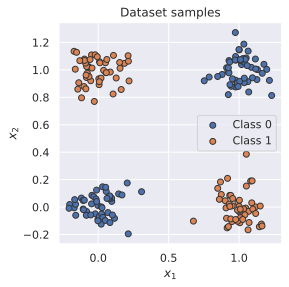

In [64]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [65]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [66]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[-0.08254972 -0.03213858]
 [ 1.0005244   0.00469806]
 [ 0.93481636  0.00473987]
 [ 1.0097677  -0.07730098]
 [ 0.7528356   0.9203105 ]
 [ 0.15231241  1.0538911 ]
 [ 0.9549934   0.06228499]
 [ 1.0276691   1.0827184 ]]
Data labels (8,) 
 [0 1 1 1 0 1 1 0]


### Optimization

In [67]:
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

Stochastic gradient descent optimizer

In [68]:
optimizer = optax.sgd(learning_rate=0.1)

Since gradients are obtained via function transformations, we dont have functions like backward(), step() like in pytorch. Instead we have a train_state object which bundles, parameters, optimizers and forward step of the model

In [69]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

### Loss Function

In [70]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

We explicilty add `params` as input argument since we want to calculate gradients with respect to them later

In [71]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.6557293, dtype=float32), Array(0.375, dtype=float32))

### Creating training and validation step

- Inputs: training state and batch
- We then calculate loss for input and take gradients of it
- Finally, we update parameters with our optimizer and return new state

In [73]:
@jax.jit
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
            argnums=1,  # Parameters are second argument of the function
            has_aux=True  # Function has additional outputs, here accuracy
            )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [74]:
@jax.jit
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [75]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [76]:
def train_model(state, data_loader, num_epochs=100):
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
    return state

In [77]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

### Saving the model

In [78]:
from flax.training import checkpoints

In [82]:
checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

In [81]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

### Evaluation

In [83]:
test_dataset = XORDataset(size=500, seed=123)
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

In [84]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [85]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


### Binding model parameters

- Bit annoying to write model.apply(params, ...) and keep track of model and params separately. We bind flex's module to specific params to simplify our application

In [86]:
trained_model = model.bind(trained_model_state.params)

In [87]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

###Visualizing the classification boundaries

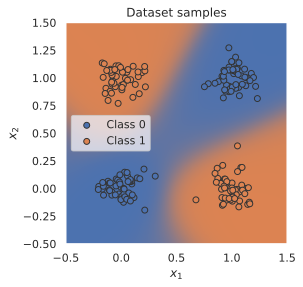

In [88]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()